# Discover

For inspiration on EDA for image analysis, I have learned from these notebooks: [SimpleEDA](https://www.kaggle.com/artgor/simple-eda-and-model-in-pytorch), [ChannelStats](https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93)

In [0]:
!pip install tensorflow==2.0.0

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
%matplotlib inline
from PIL import Image
import tensorflow as tf
import time
import zipfile
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import keras
#! tensorboard --logdir=./tensorboard_logs --port=6006
%load_ext tensorboard

In [0]:
# THIS NEEDS TO BE 2.0.0: 
tf.version.VERSION

'2.0.0'

In [0]:
from google.colab import files
uploaded = files.upload()



Saving kaggle.json to kaggle.json


In [0]:
root_dir = '/content/competitions/histopathologic-cancer-detection/'
root_logdir = os.path.join(root_dir, "tensorboard_logs")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [0]:
#!mkdir -p ~/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle config set -n path -v '/content/'
!kaggle competitions download histopathologic-cancer-detection

- path is now set to: /content/
  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 88.5MB/s]
 98% 5.00M/5.10M [00:00<00:00, 20.9MB/s]
100% 5.10M/5.10M [00:00<00:00, 20.3MB/s]
100% 1.30G/1.30G [00:24<00:00, 37.2MB/s]
100% 1.30G/1.30G [00:24<00:00, 57.8MB/s]
100% 4.97G/4.98G [01:49<00:00, 57.7MB/s]
100% 4.98G/4.98G [01:49<00:00, 48.8MB/s]


In [0]:
os.chdir(root_dir)

for path_to_zip_file in os.listdir():
    new_directory = os.path.splitext(path_to_zip_file)[0]
    os.makedirs(new_directory, exist_ok=True)
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
      zip_ref.extractall(new_directory)
      zip_ref.close()

In [0]:
! ls -l | head -10

total 6617084
drwxr-xr-x 2 root root       4096 Oct 16 17:46 sample_submission.csv
-rw-r--r-- 1 root root    1394488 Oct 16 17:44 sample_submission.csv.zip
drwxr-xr-x 2 root root    4386816 Oct 16 17:48 test
-rw-r--r-- 1 root root 1401100547 Oct 16 17:44 test.zip
drwxr-xr-x 2 root root   16666624 Oct 16 17:48 train
drwxr-xr-x 2 root root       4096 Oct 16 17:46 train_labels.csv
-rw-r--r-- 1 root root    5352900 Oct 16 17:44 train_labels.csv.zip
-rw-r--r-- 1 root root 5346961539 Oct 16 17:46 train.zip


In [0]:
!pwd

/content/competitions/histopathologic-cancer-detection


In [0]:
train_path = os.path.join(root_dir, 'train/')
test_path = os.path.join(root_dir, 'test/')
train_labels_path = os.path.join(root_dir, 'train_labels.csv/train_labels.csv')

In [0]:
train_df = pd.read_csv(train_labels_path)

In [0]:
train_df.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [0]:
print(f'{len(os.listdir(train_path))} pictures in train.')
print(f'{len(os.listdir(test_path))} pictures in test.')

220025 pictures in train.
57458 pictures in test.


## Visualize some images:

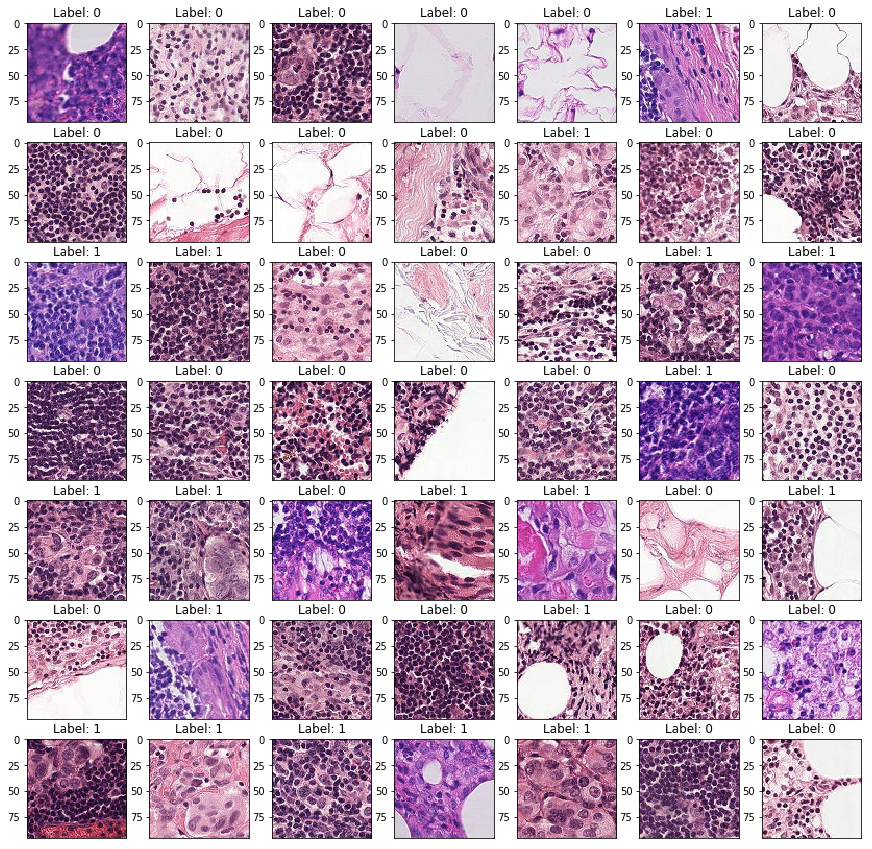

In [0]:
train_set = os.listdir(train_path)
fig, axes = plt.subplots(nrows = 7, ncols = 7, figsize=(15, 15))
axes = axes.reshape(-1)
for idx, img in enumerate(np.random.choice(train_set, 49)):
    im = Image.open(train_path + img)
    axes[idx].imshow(im)
    #lab = labels.loc[labels['id'] == img.split('.')[0], 'label'].values[0]
    lab = train_df.loc[train_df['id'] == img.split('.')[0], 'label'].values[0]
    axes[idx].set_title(f'Label: {lab}')
    axes[idx].set_xticks([], [])


## Check that the training set is balanced:

In [0]:
train_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [24]:
train_df['label'].value_counts()/sum(train_df['label'].value_counts())

0    0.7
1    0.3
Name: label, dtype: float64

## Channel Distributions

In [0]:
train_df['id'] = train_df['id'].apply(lambda x: x+".tif")
batch_size = 1
# !!!!!!
train_df = pd.DataFrame(train_df.head(10))
train_df = train_df.astype({'label': 'str'})

#positive_samples = train_df[train_df['label']==1]
#negative_samples = train_df[train_df['label']==0]

#positive_samples = positive_samples.astype({'label': 'str'})
#negative_samples = negative_samples.astype({'label': 'str'})


In [45]:
negative_samples

id label
0  f38a6374c348f90b587e046aac6079959adf3835.tif     0
2  755db6279dae599ebb4d39a9123cce439965282d.tif     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif     0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif     0
5  acfe80838488fae3c89bd21ade75be5c34e66be7.tif     0
8  559e55a64c9ba828f700e948f6886f4cea919261.tif     0
9  8eaaa7a400aa79d36c2440a4aa101cc14256cda4.tif     0

In [67]:
pars = {'directory': train_path, 
                'x_col': 'id', # filenames of images
                'y_col': 'label', # class
                'target_size': (96, 96),
                'class_mode':'binary',
                'batch_size': batch_size}

train_data_gen = ImageDataGenerator() 
train_generator = train_data_gen.flow_from_dataframe(train_df, **pars)
#negative_generator = train_data_gen.flow_from_dataframe(negative_samples, **pars)

Found 10 validated image filenames belonging to 2 classes.


In [0]:
def add_summary(data, n_bins, step, prefix = ''):
  tf.summary.histogram(prefix + 'rgb_histogram', data, buckets = n_bins, step = step)
  tf.summary.histogram(prefix + 'red_histogram', data[:,:,:,0], buckets = n_bins, step = step)
  tf.summary.histogram(prefix + 'blue_histogram', data[:,:,:,1], buckets = n_bins, step = step)
  tf.summary.histogram(prefix + 'green_histogram', data[:,:,:,2], buckets = n_bins, step = step)


def create_summary_histograms(data_generator, binary_class = 'all', n_bins = 256, run_name = None):
  """ This method will use an ImageDataGenerator flow to go through all the training
  images and create histograms of the red, green, blue, and total intensity values.
  It is useful to set for example class = positive_only and then run it again for
  class = negative_only so that positive and negative samples can be compared 
  side by side in the tensorboard visualization rather than as
  separate drop-down histograms."""

  total_steps = data_generator.samples
  target_steps = total_steps - 1
  
  run_logdir = get_run_logdir()
  if run_name is not None:
    run_logdir = run_logdir + '_' + run_name

  writer = tf.summary.create_file_writer(run_logdir)
  prog_bar = tf.keras.utils.Progbar(
      target_steps,
      width=30,
      verbose=1,
      interval=0.05,
      stateful_metrics=None,
      unit_name='step')

  with writer.as_default():
      batch = 0
      for x_batch, y_batch in data_generator:
          prog_bar.update(batch)

          positive_samples = x_batch[y_batch==1,:,:,:]
          negative_samples = x_batch[y_batch==0,:,:,:]
          if binary_class=='all':
            # More specific labels are necessary:
            add_summary(positive_samples, n_bins, batch, 'pos_')
            add_summary(negative_samples, n_bins, batch, 'neg_')

          elif binary_class=='positive_only':
            add_summary(positive_samples, n_bins, batch)

          elif binary_class=='negative_only':
            add_summary(negative_samples, n_bins, batch)
            
          writer.flush()
          batch += 1
          if batch >= total_steps / batch_size: #len(train_df) / batch_size: 
                  # we need to break the loop by hand because
                  # the generator loops indefinitely
              break
  return run_logdir

In [102]:
run1 = create_summary_histograms(train_generator, binary_class = 'positive_only', run_name = 'Positive')
run2 = create_summary_histograms(train_generator, binary_class = 'negative_only', run_name = 'Negative')


9/9 [==============================] - 1s 62ms/step


In [100]:
# using the variable root_logdir was not working here:
%tensorboard --logdir '/content/competitions/histopathologic-cancer-detection/tensorboard_logs'

Reusing TensorBoard on port 6006 (pid 1935), started 0:43:36 ago. (Use '!kill 1935' to kill it.)

In [0]:
96*96

9216

In [109]:
# This example supposes that the events file contains summaries with a
# summary value tag 'loss'.  These could have been added by calling
# `add_summary()`, passing the output of a scalar summary op created with
# with: `tf.compat.v1.summary.scalar('loss', loss_tensor)`.

os.chdir(run1)
for event_file in os.listdir():
  for e in tf.compat.v1.train.summary_iterator(event_file):
      for v in e.summary.value:
          if v.tag == 'green_histogram':
              print(v.histo.SerializeToString())


# Here I want to cycle over the event files and create one summary histogram (sum of the histograms for all the images)
# for visualization in cases where tensorboard cannot be loaded:



b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


In [0]:
# FOR ANOTHER TIME (Ie. Modelling)
 # Build and compile your model
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])